In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.estela import spatial_gradient, mask_from_poly, Predictor
from teslakit.plotting.estela import Plot_ESTELA
from teslakit.plotting.wts import Plot_Probs_WT_WT



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# load data and set parameters

ls_sea_poly = db.Load_ESTELA_coast()         # ESTELA coastline (land mask)
xds_est = db.Load_ESTELA_data()              # ESTELA D data
xds_WAVES = db.Load_ESTELA_waves()           # ESTELA gow waves point
print(xds_WAVES)
xds_SLP_site = db.Load_ESTELA_SLP()          # ESTELA Sea Level Pressure
xds_wvs_pts = db.Load_WAVES_partitions()     # waves partitions data

_, xds_TCs_r1_params = db.Load_TCs_r1()      # TCs historical parameters inside 14º radius 

# KMA REGRESSION GUIDED parameters
kma_date_ini = '1979-01-22'
kma_date_end = '2011-01-22'
num_clusters = 36
kmarg_alpha = 0.36

# waves point coordinates
pnt_lon = 167.5
pnt_lat = 9.75


<xarray.Dataset>
Dimensions:  (time: 336000)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2017-04-30T23:00:00.000013
Data variables:
    fp       (time) float64 0.1 0.101 0.101 0.101 ... 0.108 0.108 0.108 0.108
    hs       (time) float64 3.248 3.348 3.394 3.394 ... 2.228 2.298 2.372 2.444
    t02      (time) float64 6.17 6.06 6.09 6.14 6.16 ... 5.49 5.48 5.51 5.57
    dir      (time) float64 56.3 57.4 58.5 59.5 60.1 ... 60.2 60.2 60.0 59.6
    spr      (time) float64 32.4 32.0 32.1 32.3 32.5 ... 33.7 33.4 33.0 32.7
    hsCal    (time) float64 3.347 3.498 3.581 3.598 ... 2.084 2.17 2.261 2.35
Attributes:
    lat:      9.5
    lon:      167.25
    bat:      3165.8977777777777
    forcing:  CFS
    mesh:     Plataforma



## ESTELA Predictor - Sea Level Pressure and Gradient

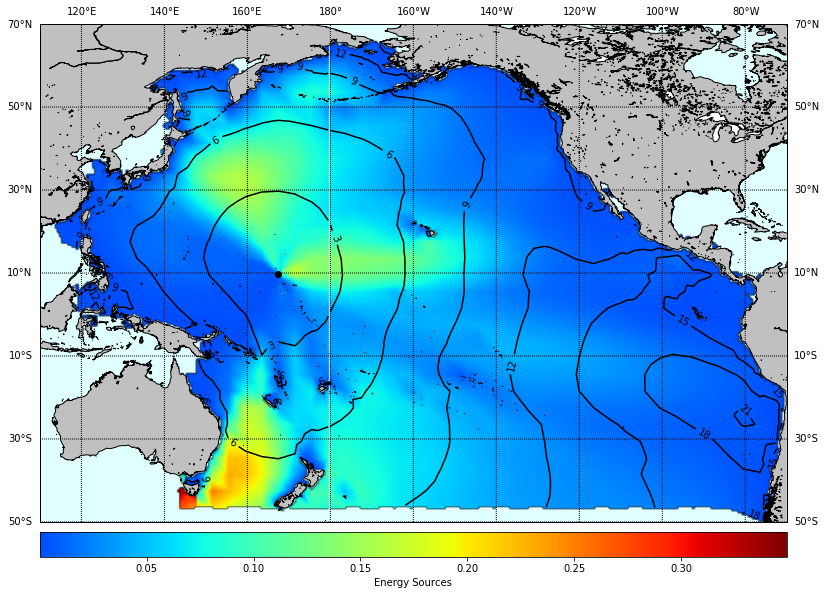

In [4]:
# --------------------------------------
# Plot ESTELA and wave point coordinates

Plot_ESTELA(
    pnt_lon, pnt_lat, xds_est.F_y1993to2012, xds_est.D_y1993to2012,
    lon1 = 110, lon2 = 290, lat1 = -50, lat2 = 70,
)


In [5]:
# --------------------------------------
# ESTELA waves data: calculate Fe, resample to daily

# calculate Fe
hs = xds_WAVES.hs
tm = xds_WAVES.t02
Fe = np.multiply(hs**2,tm)**(1.0/3)
xds_WAVES.update({
    'Fe':(('time',), Fe)
})

# select time window and calculate daily mean
xds_WAVES = xds_WAVES.sel(
    time = slice(kma_date_ini, kma_date_end)
).resample(time='1D').mean()

print(xds_WAVES)


<xarray.Dataset>
Dimensions:  (time: 11689)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-01-22
Data variables:
    fp       (time) float64 0.1037 0.09292 0.09458 ... 0.07067 0.06604 0.07121
    hs       (time) float64 3.105 2.933 2.88 2.24 ... 2.177 2.395 2.55 2.305
    t02      (time) float64 6.059 6.032 5.998 5.773 ... 6.9 8.265 7.428 6.794
    dir      (time) float64 58.25 55.27 58.52 55.72 ... 159.7 351.0 165.9 10.58
    spr      (time) float64 39.06 40.38 36.42 38.68 ... 47.4 41.82 39.79 42.83
    hsCal    (time) float64 3.191 2.935 2.898 2.101 ... 2.006 2.09 2.379 2.23
    Fe       (time) float64 3.879 3.729 3.677 3.07 ... 3.198 3.619 3.641 3.304


In [6]:
# --------------------------------------
# Calculate site SLP & SLP_gradient (daily)

# select time window and do data daily mean
xds_SLP_day = xds_SLP_site.sel(
    time = slice(kma_date_ini, kma_date_end)
).resample(time='1D').mean()

# calculate daily gradients
xds_SLP_day = spatial_gradient(xds_SLP_day, 'SLP')

# use coastline polygons to generate a land mask
xds_SLP_day = mask_from_poly(xds_SLP_day, ls_sea_poly, 'mask_land')
    

In [7]:
# --------------------------------------
# Select site ESTELA and generate ESTELA land mask

# select ESTELA at site grid
xds_est_site = xds_est.sel(
    longitude = xds_SLP_site.longitude,
    latitude = xds_SLP_site.latitude,
)
estela_D = xds_est_site.D_y1993to2012

# use ESTELA to generate ESTELA mask
mask_est = np.zeros(estela_D.shape)
mask_est[np.where(estela_D<1000000000)]=1

xds_SLP_day.update({'mask_estela':(('latitude','longitude'), mask_est)})

print(xds_SLP_day)


<xarray.Dataset>
Dimensions:       (latitude: 31, longitude: 83, time: 11689)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-01-22
  * latitude      (latitude) float64 60.5 58.5 56.5 54.5 ... 6.5 4.5 2.5 0.5
  * longitude     (longitude) float64 115.0 117.0 119.0 ... 275.0 277.0 279.0
Data variables:
    SLP           (time, latitude, longitude) float64 1.019e+05 ... 1.009e+05
    SLP_gradient  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0
    mask_land     (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    mask_estela   (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0



## ESTELA Predictor - Principal Component Analysis

In [8]:
# --------------------------------------
# Calculate ESTELA PCA

# Use our custom ESTELA Predictor 
pred = Predictor(db.paths.site.ESTELA.pred_slp)
pred.data = xds_SLP_day

# PCA (dynamic estela predictor)
pred.Calc_PCA_EstelaPred('SLP', estela_D)

print(pred.PCA)


<xarray.Dataset>
Dimensions:        (n_components: 3594, n_features: 3594, n_lat: 31, n_lon: 83, n_points: 5146, time: 11668)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 6.459 -8.461 ... -1.144e-15
    EOFs           (n_components, n_features) float64 0.0359 0.03646 ... 0.0 1.0
    variance       (n_components) float64 420.7 228.8 ... 2.474e-30 2.474e-30
    pred_mean      (n_features) float64 1.012e+05 1.013e+05 ... 0.0 0.0
    pred_std       (n_features) float64 553.4 619.2 536.6 429.2 ... 0.0 0.0 0.0
    pred_lon       (n_lon) float64 115.0 117.0 119.0 121.0 ... 275.0 277.0 279.0
    pred_lat       (n_lat) float64 60.5 58.5 56.5 54.5 52.5 ... 6.5 4.5 2.5 0.5
    pred_time      (time) datetime64[ns] 1979-02-12 1979-02-13 ... 2011-01-22
    pred_data_pos  (n_points) bool False False False False ... True True True
Attributes:
    method:     gradient + estela
    pred_name:  SLP


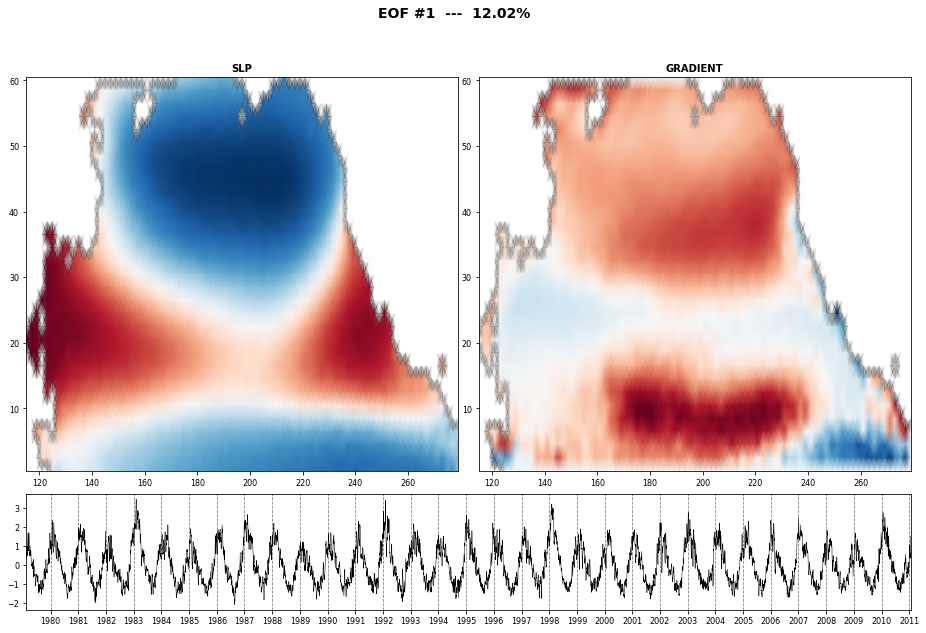

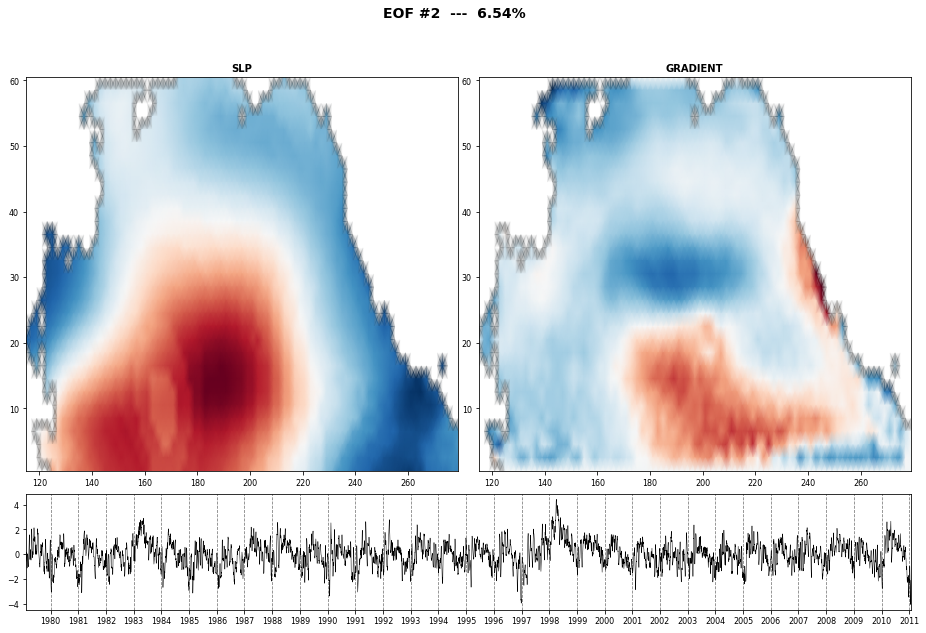

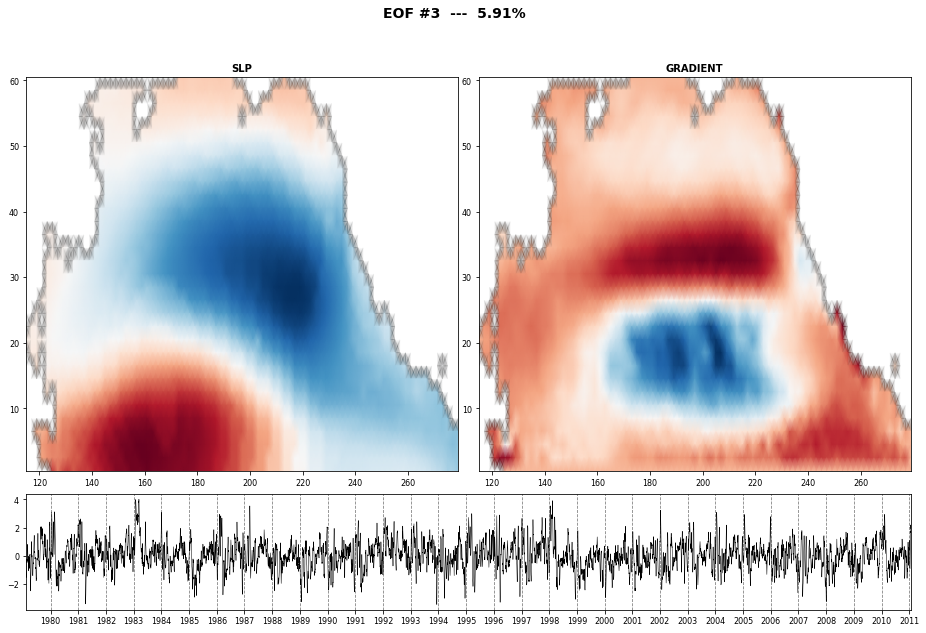

In [9]:
# plot PCA EOFs
n_EOFs = 3
pred.Plot_EOFs_EstelaPred(n_EOFs, show=True)



## ESTELA Predictor - KMeans Classification

In [10]:
# Calculate KMA (regression guided with WAVES data)

# TODO: encontrar alpha optimo?
pred.Calc_KMA_regressionguided(
    num_clusters,
    xds_WAVES, ['hs','t02','Fe'],
    kmarg_alpha)

print(pred.KMA)


<xarray.Dataset>
Dimensions:           (n_clusters: 36, n_components: 11668, n_features: 432)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus              (n_components) int32 20 20 4 4 19 19 ... 22 25 25 25 25 22
    cenEOFs           (n_clusters, n_features) float64 -0.5685 ... 0.2078
    centroids         (n_clusters, n_features) float64 -18.22 -8.227 ... 2.938
    group_size        (n_clusters) int64 25 225 463 306 311 ... 136 48 658 351
    sorted_order      (n_clusters) int64 15 26 22 25 12 32 2 ... 0 33 6 11 1 29
    sorted_bmus       (n_components) int64 22 22 21 21 15 15 15 ... 2 3 3 3 3 2
    sorted_cenEOFs    (n_clusters, n_features) float64 -0.8309 -0.5071 ... 1.29
    sorted_centroids  (n_clusters, n_features) float64 -26.63 -16.25 ... 4.565
    time              (n_components) datetime64[ns] 1979-02-12 ... 2011-01-22
Attributes:
    method:   regression guided
    alpha:    0.36


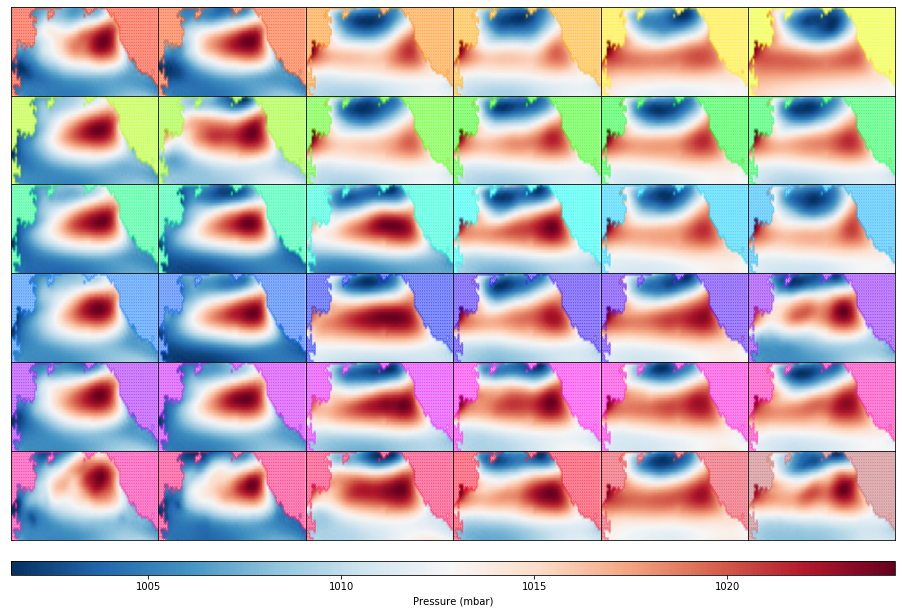

In [11]:
# Plot DWTs (data mean)
pred.Plot_DWTs('SLP', show=True, mask='mask_estela')


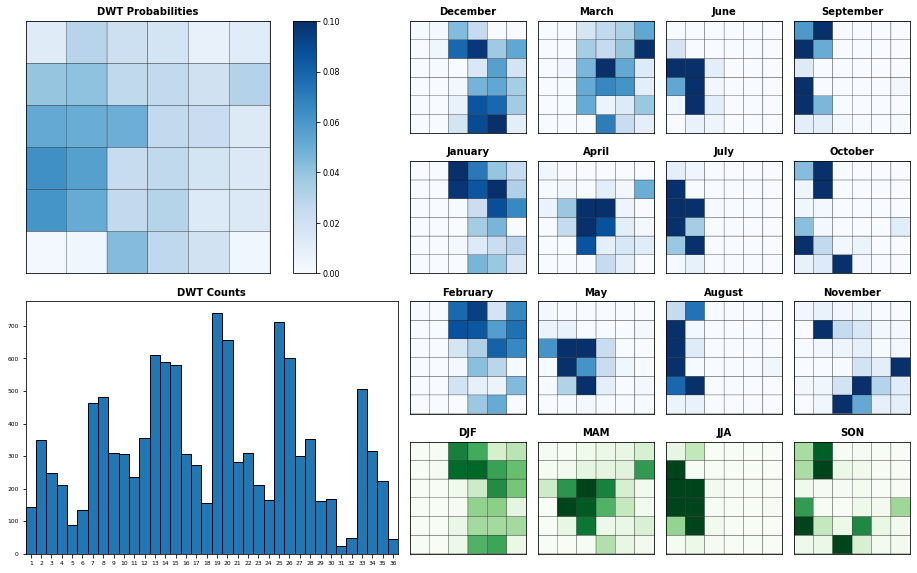

In [12]:
# Plot DWTs Probabilities
pred.Plot_DWTs_Probs()


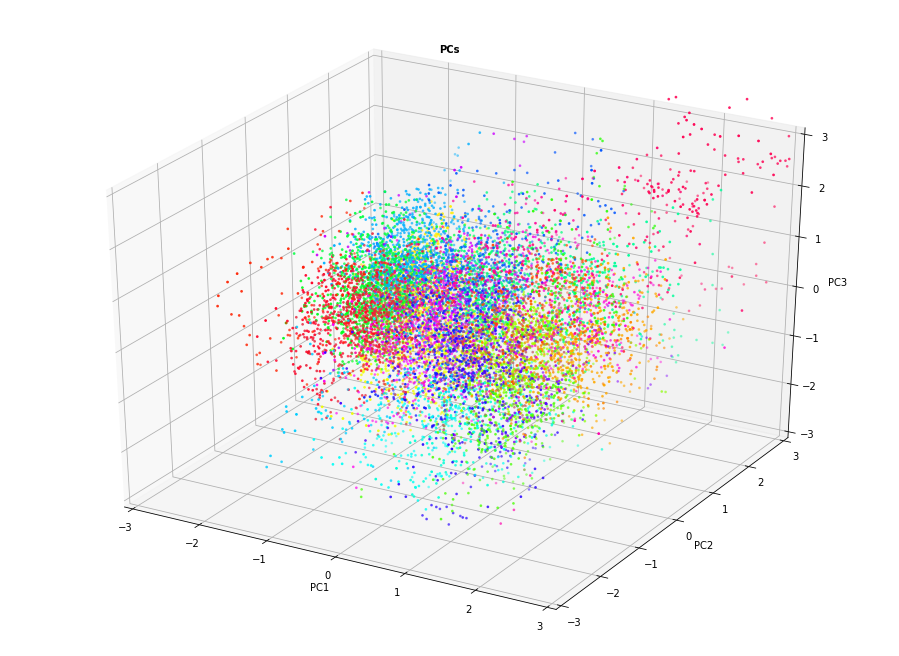

In [13]:
# Plot PC1, PC2, PC3 (3D)
pred.Plot_PCs_3D()


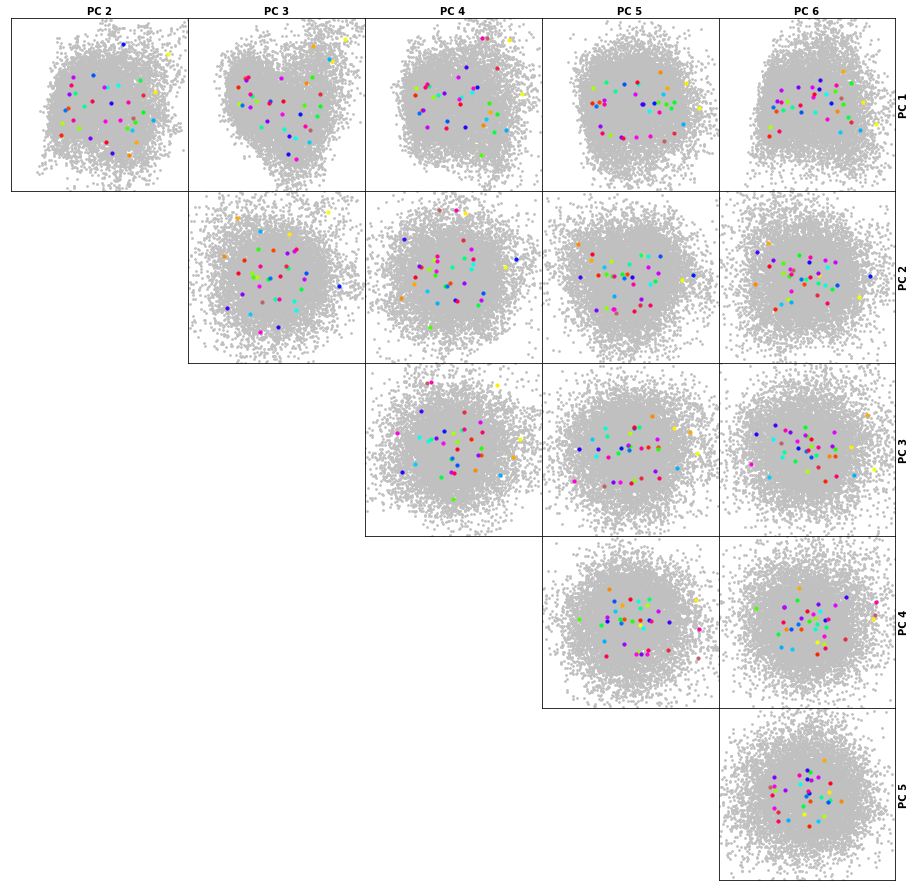

In [14]:
# Plot PCs DWT centroids
pred.Plot_DWT_PCs(n=6)



## ESTELA Predictor - Add Historical TCs

In [15]:
# --------------------------------------
# use historical storms-parameters inside r1 to modify predictor KMA results 

storm_dates = xds_TCs_r1_params.dmin_date.values[:]
storm_categs = xds_TCs_r1_params.category.values[:]

# add r1 storms to predictor KMA
pred.Mod_KMA_AddStorms(storm_dates, storm_categs)

print(pred.KMA)


<xarray.Dataset>
Dimensions:             (n_clusters: 36, n_components: 11668, n_features: 432)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus                (n_components) int32 20 20 4 4 19 19 ... 25 25 25 25 22
    cenEOFs             (n_clusters, n_features) float64 -0.5685 ... 0.2078
    centroids           (n_clusters, n_features) float64 -18.22 -8.227 ... 2.938
    group_size          (n_clusters) int64 25 225 463 306 311 ... 136 48 658 351
    sorted_order        (n_clusters) int64 15 26 22 25 12 32 ... 0 33 6 11 1 29
    sorted_bmus         (n_components) int64 22 22 21 21 15 15 ... 2 3 3 3 3 2
    sorted_cenEOFs      (n_clusters, n_features) float64 -0.8309 ... 1.29
    sorted_centroids    (n_clusters, n_features) float64 -26.63 -16.25 ... 4.565
    time                (n_components) datetime64[ns] 1979-02-12 ... 2011-01-22
    sorted_bmus_storms  (n_components) int64 22 22 21 21 15 15 ... 2 3 3 3 3 2
Attributes:
    method:   re

In [16]:
# --------------------------------------
# Calculate intradaily MU TAU hydrographs

l_xds_MUTAU = pred.Calc_MU_TAU_Hydrographs(xds_wvs_pts)

# store hydrographs MU TAU
db.Save_MU_TAU_hydrograms(l_xds_MUTAU)

# TODO: plot report hydrographs

In [24]:
print(MJO_phase)
print(DWT_bmus)

[2 2 2 ... 6 6 6]
[22 22 21 ...  3  3  2]


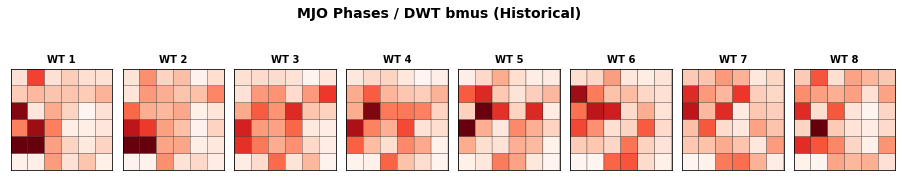

In [17]:
# Plot MJO phases / DWTs Probabilities 

# num. MJO phases and DWTs
MJO_ncs = 8
DWT_ncs = 36

# MJO, DWTs historical data
xds_MJO_hist, xds_DWT_hist = db.Load_MJO_DWTs_Plots_hist()

# categories to plot
MJO_phase = xds_MJO_hist.phase.values[:]
DWT_bmus = xds_DWT_hist.bmus.values[:]

Plot_Probs_WT_WT(
    MJO_phase, DWT_bmus, MJO_ncs, DWT_ncs,
    wt_colors=False, ttl='MJO Phases / DWT bmus (Historical)')
